In [7]:
import torch
import clip

# Load CLIP model and the tokenizer
device = "mps"
model, preprocess = clip.load("ViT-B/32")
model = model.to(device)

# Define the fully connected layer
class CLIPWithFC(torch.nn.Module):
    def __init__(self, clip_model, output_dim):
        super(CLIPWithFC, self).__init__()
        self.clip_model = clip_model
        self.fc = torch.nn.Linear(clip_model.visual.output_dim * 2, output_dim) # for concatenated dimensions

    def forward(self, image, text):
        with torch.no_grad():
            # Encode image and text with CLIP
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)

        # Combine embeddings (here, we're just concatenating as both are in the same embedding space)
        combined_features = torch.cat((image_features, text_features), dim=1)
        
        # print(combined_features.shape)
        # print(self.clip_model.visual.output_dim)
        
        # Pass through the fully connected layer
        scores = self.fc(combined_features)
        return scores

# Create the model instance
output_dim = 1  # Assuming you want a single score as the output
model_with_fc = CLIPWithFC(model, output_dim).to(device)

# Example usage
from PIL import Image

# Prepare input image and text (adapt according to your data)
image_path = './10594-screenshot.jpg'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
text = clip.tokenize(["Your text description"]).to(device)

# Predict the score
model_with_fc.eval()  # Set the model to evaluation mode
score = model_with_fc(image, text)
print(f'Predicted Score: {score.item()}')

Predicted Score: -0.41913536190986633


In [28]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MeasuresDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        page = str(int(self.data.iloc[idx]['Page']))
        label = self.data.iloc[idx]['Final Score']
        text_description = "hi cat" # Adjust to your text column
        # text_description = self.data.iloc[idx]['Description']

        img_path = os.path.join(self.image_dir, f"{page}.jpg")
        # image = Image.open(img_path).convert('RGB')
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        # Apply transformations, if provided
        # if self.transform:
        #     image = self.transform(image)
        
        image = image.squeeze(0) if image.dim() == 4 else image
            
        text_description = clip.tokenize([text_description]).to(device)
        
        text_description = text_description.squeeze(0)

        return image, text_description, torch.tensor(label, dtype=torch.float)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as per model requirements
    transforms.ToTensor()
])

dataset = MeasuresDataset(csv_file='measures.csv', image_dir='./combined', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Epoch [1/5], MSE Loss: 0.0828
Epoch [2/5], MSE Loss: 0.0301
Epoch [3/5], MSE Loss: 0.0227
Epoch [4/5], MSE Loss: 0.0168
Epoch [5/5], MSE Loss: 0.0139


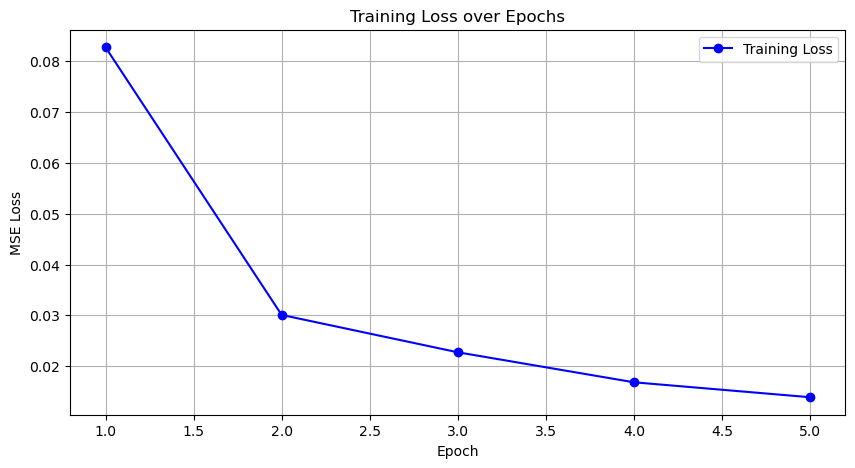

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare model, loss function, and optimizer
device = "mps"
clip_model, preprocess = clip.load("ViT-B/32")
clip_model = clip_model.to(device)
model = CLIPWithFC(clip_model, 1)  # Instantiate the CLIP model wrapper
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

all_epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, texts, labels in dataloader:
        # Move data to GPU if available
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)
        # print(images.shape, texts.shape)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(images, texts)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute and print the average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    all_epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {avg_loss:.4f}")
    
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), all_epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()